Import Initial Data

In [90]:
import os
# run once
# os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
import tensorflow as tf
# tf.config.list_physical_devices('GPU')


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[0], 'GPU')



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13511578285985094315
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5718933504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1482443426090961942
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [131]:
# imports 
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
# Figure out how to import this model 
# from tensorflow.keras.applications.resnet50v2 import ResNet50V2

In [15]:
# Note: There are only 8 images per label here, so we're going to have to change what we do here 
# Confirmed that the # of images in the 3 folders sum to 5,856, which is the total number of images 


SPLIT DATA RUN ONLY ONCE !!!!!!

In [132]:
# Split data set into train, val, and test
# just change the directory
# ONLY RUN ONCE DO NOT RUN AGAIN
# import splitfolders

# splitfolders.ratio("D:\Paul_Backup\paulj\Pneumonia-Classification\src\data", output = "D:\Paul_Backup\paulj\Pneumonia-Classification\src\data_split", seed = 1337, ratio = (0.6,0.2,0.2), group_prefix=None, move=False)

# add code to check for data_split directory if exists delete and create again or don't run 


In [133]:
# Training data: 3512
print(os.getcwd())
train_data = keras.utils.image_dataset_from_directory(
    'D:\\Paul_Backup\\paulj\\Pneumonia-Classification\\src\\data_split\\train',
    image_size=(256, 256), 
    batch_size=32, 
    seed = 10
)

d:\Paul_Backup\paulj\Pneumonia-Classification\src\test_notebooks\paul_test
Found 3512 files belonging to 2 classes.


In [134]:
# Validation data: 1170
val_data = keras.utils.image_dataset_from_directory(
    'D:\\Paul_Backup\\paulj\\Pneumonia-Classification\\src\\data_split\\val',
    image_size=(256, 256), 
    batch_size=32, 
    seed = 10
)

Found 1170 files belonging to 2 classes.


In [135]:
# Test data: 1174
test_data = keras.utils.image_dataset_from_directory(
    'D:\\Paul_Backup\\paulj\\Pneumonia-Classification\\src\\data_split\\test',
    image_size=(256, 256), 
    batch_size=32, 
)

Found 1174 files belonging to 2 classes.


In [89]:
fulltrain = train_data.concatenate(val_data)


In [42]:
len(list(fulltrain))

147

In [43]:
tf.data.experimental.cardinality(fulltrain)

<tf.Tensor: shape=(), dtype=int64, numpy=147>

In [45]:
tf.data.experimental.cardinality(val_data)

<tf.Tensor: shape=(), dtype=int64, numpy=37>

In [46]:
tf.data.experimental.cardinality(train_data)

<tf.Tensor: shape=(), dtype=int64, numpy=110>

Initial ResNet 50 Model:

In [137]:
# Function to build model 
def build_resnet50_model(drop_rate):
    
    # Define input shape for the model 
    inputs = keras.Input(shape = (256, 256, 3))
    # Resnet 50 basemodel 
    base_model = ResNet50(input_shape = (256, 256, 3), weights = 'imagenet', include_top = False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
 
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [81]:
# Build the model: 
resnet50_mod = build_resnet50_model(drop_rate)

In [82]:
# Function to fit model 
def fit_model(model, train_set, validation_set):
    """Fit a model with the above stated criteria"""
    # Set patience to 5 so it doesn't take too long to fit 
    early_stopping = keras.callbacks.EarlyStopping(patience = 5)
    
    model.fit(train_set, 
              validation_data = validation_set, 
              callbacks = [early_stopping], 
              epochs = 500)
    
    return model

In [83]:
# Fit the model: 
# Started 12:18 pm; ended 12:55 pm --> 37 min to train 
# Best model: 
fitted_resnet50_mod = fit_model(resnet50_mod, train_data, val_data)

Epoch 1/500
110/110 [==============================] - 10s 63ms/step - loss: 4.1018 - accuracy: 0.9052 - val_loss: 0.2027 - val_accuracy: 0.9462
Epoch 2/500
110/110 [==============================] - 6s 57ms/step - loss: 0.3226 - accuracy: 0.9462 - val_loss: 0.2598 - val_accuracy: 0.9547
Epoch 3/500
110/110 [==============================] - 6s 57ms/step - loss: 0.2105 - accuracy: 0.9655 - val_loss: 0.1572 - val_accuracy: 0.9538
Epoch 4/500
110/110 [==============================] - 6s 57ms/step - loss: 0.1836 - accuracy: 0.9690 - val_loss: 0.2464 - val_accuracy: 0.9581
Epoch 5/500
110/110 [==============================] - 6s 57ms/step - loss: 0.1050 - accuracy: 0.9778 - val_loss: 0.1235 - val_accuracy: 0.9692
Epoch 6/500
110/110 [==============================] - 6s 57ms/step - loss: 0.1078 - accuracy: 0.9795 - val_loss: 0.2403 - val_accuracy: 0.9650
Epoch 7/500
110/110 [==============================] - 6s 57ms/step - loss: 0.0806 - accuracy: 0.9860 - val_loss: 0.4862 - val_accuracy

In [138]:
drop_rate = 0.02
result_dict = {}
while drop_rate <= 0.5:
    resnet50_mod = build_resnet50_model(drop_rate)
    fitted_resnet50_mod = fit_model(resnet50_mod, train_data, val_data)
    result_dict[drop_rate] = fitted_resnet50_mod.evaluate(test_data)
    drop_rate += 0.02

Epoch 1/500
110/110 [==============================] - 16s 108ms/step - loss: 8.8018 - accuracy: 0.9080 - val_loss: 0.2947 - val_accuracy: 0.9675
Epoch 2/500
110/110 [==============================] - 11s 98ms/step - loss: 0.5402 - accuracy: 0.9462 - val_loss: 1.3629 - val_accuracy: 0.8880
Epoch 3/500
110/110 [==============================] - 11s 97ms/step - loss: 0.3069 - accuracy: 0.9644 - val_loss: 0.3733 - val_accuracy: 0.9675
Epoch 4/500
110/110 [==============================] - 11s 98ms/step - loss: 0.2092 - accuracy: 0.9741 - val_loss: 0.5942 - val_accuracy: 0.9607
Epoch 5/500
110/110 [==============================] - 11s 97ms/step - loss: 0.2054 - accuracy: 0.9775 - val_loss: 0.3031 - val_accuracy: 0.9641
Epoch 6/500
110/110 [==============================] - 11s 97ms/step - loss: 0.0735 - accuracy: 0.9869 - val_loss: 0.2709 - val_accuracy: 0.9658
Epoch 7/500
110/110 [==============================] - 11s 98ms/step - loss: 0.0794 - accuracy: 0.9903 - val_loss: 0.3105 - val_a

In [139]:
result_dict

{0.02: [0.32337895035743713, 0.9718909859657288],
 0.04: [0.24860438704490662, 0.9727427363395691],
 0.06: [0.27088576555252075, 0.9752981066703796],
 0.08: [0.7759113907814026, 0.9735945463180542],
 0.1: [0.12189581245183945, 0.9778534770011902],
 0.12000000000000001: [0.25513723492622375, 0.9693356156349182],
 0.14: [1.2328615188598633, 0.9165247082710266],
 0.16: [0.2246522456407547, 0.9659284353256226],
 0.18: [0.15865661203861237, 0.9693356156349182],
 0.19999999999999998: [0.3319864273071289, 0.9718909859657288],
 0.21999999999999997: [0.2862241268157959, 0.9727427363395691],
 0.23999999999999996: [0.278745174407959, 0.9710391759872437],
 0.25999999999999995: [0.3354964554309845, 0.9752981066703796],
 0.27999999999999997: [0.2311326265335083, 0.9676320552825928],
 0.3: [0.19375668466091156, 0.9727427363395691],
 0.32: [0.13530941307544708, 0.9684838056564331],
 0.34: [0.3218041658401489, 0.9718909859657288],
 0.36000000000000004: [0.8927669525146484, 0.9258943796157837],
 0.38000

In [84]:
fitted_resnet50_mod.evaluate(test_data)

37/37 [==============================] - 2s 40ms/step - loss: 0.2985 - accuracy: 0.9719


[0.2985367178916931, 0.9718909859657288]

Initial Inception V3 model

In [27]:
# Function to build model 
def build_inceptionV3_model(drop_rate):
    
    # Define input shape for the model 
    inputs = keras.Input(shape = (180, 180, 3))
    # InceptionV3 base model 
    base_model = InceptionV3(input_shape = (180, 180, 3), weights = 'imagenet', include_top = False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
 
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [28]:
# Build the model: 
inceptionV3_mod = build_inceptionV3_model()

87910968/87910968 [==============================] - 3s 0us/step


In [29]:
# Fit the model: 
# Started 12:48 pm; ended pm --> 9 min to train 
fitted_inceptionV3_mod = fit_model(inceptionV3_mod, train_data, val_data)

Epoch 1/500
110/110 [==============================] - 9s 54ms/step - loss: 45.4147 - accuracy: 0.8260 - val_loss: 0.2524 - val_accuracy: 0.9162
Epoch 2/500
110/110 [==============================] - 5s 46ms/step - loss: 3.0751 - accuracy: 0.8331 - val_loss: 0.6364 - val_accuracy: 0.8940
Epoch 3/500
110/110 [==============================] - 5s 45ms/step - loss: 1.3997 - accuracy: 0.8485 - val_loss: 0.4082 - val_accuracy: 0.9051
Epoch 4/500
110/110 [==============================] - 5s 44ms/step - loss: 1.0579 - accuracy: 0.8730 - val_loss: 0.2310 - val_accuracy: 0.9385
Epoch 5/500
110/110 [==============================] - 5s 44ms/step - loss: 0.6529 - accuracy: 0.8682 - val_loss: 0.3089 - val_accuracy: 0.9239
Epoch 6/500
110/110 [==============================] - 5s 44ms/step - loss: 0.6720 - accuracy: 0.8687 - val_loss: 0.2724 - val_accuracy: 0.9419
Epoch 7/500
110/110 [==============================] - 5s 44ms/step - loss: 0.5545 - accuracy: 0.8767 - val_loss: 0.2505 - val_accuracy

In [34]:
fitted_inceptionV3_mod.evaluate(test_data)

37/37 [==============================] - 2s 37ms/step - loss: 0.6130 - accuracy: 0.9216


[0.6129802465438843, 0.9216354489326477]

In [65]:
# Function to build model 
def build_resnet50V2_model(drop_rate):
    
    # Define input shape for the model 
    inputs = keras.Input(shape = (180, 180, 3))
    # Resnet 50 basemodel 
    base_model = ResNet50V2(input_shape = (180, 180, 3), weights = 'imagenet', include_top = False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = keras.applications.resnet_v2.preprocess_input(inputs)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
 
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [66]:
# Build the model: 
resnet50V2_mod = build_resnet50V2_model()

In [67]:
# Fit the model: 
# Started 12:48 pm; ended pm --> 9 min to train 
resnet50V2_mod = fit_model(resnet50V2_mod, train_data, val_data)

Epoch 1/500
110/110 [==============================] - 10s 62ms/step - loss: 1.9958 - accuracy: 0.8944 - val_loss: 0.1643 - val_accuracy: 0.9265
Epoch 2/500
110/110 [==============================] - 6s 56ms/step - loss: 0.2709 - accuracy: 0.9342 - val_loss: 0.1457 - val_accuracy: 0.9556
Epoch 3/500
110/110 [==============================] - 7s 58ms/step - loss: 0.2631 - accuracy: 0.9513 - val_loss: 0.1783 - val_accuracy: 0.9504
Epoch 4/500
110/110 [==============================] - 6s 57ms/step - loss: 0.1821 - accuracy: 0.9638 - val_loss: 0.1727 - val_accuracy: 0.9547
Epoch 5/500
110/110 [==============================] - 6s 57ms/step - loss: 0.0985 - accuracy: 0.9769 - val_loss: 0.1756 - val_accuracy: 0.9564
Epoch 6/500
110/110 [==============================] - 7s 58ms/step - loss: 0.0634 - accuracy: 0.9829 - val_loss: 0.7078 - val_accuracy: 0.9239
Epoch 7/500
110/110 [==============================] - 6s 56ms/step - loss: 0.0768 - accuracy: 0.9826 - val_loss: 0.2488 - val_accuracy

In [64]:
resnet50V2_mod.evaluate(test_data)

37/37 [==============================] - 2s 39ms/step - loss: 0.5262 - accuracy: 0.9583


[0.5261532664299011, 0.9582623243331909]

In [44]:
# maybe use docker instead of pickle

import pickle
filename = 'pneumonia_inceptionV.pkl'
pickle.dump(fitted_inceptionV3_mod, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://2f0b1158-0ad8-4ee0-8529-f38bd479d67f/assets


INFO:tensorflow:Assets written to: ram://2f0b1158-0ad8-4ee0-8529-f38bd479d67f/assets


In [95]:
drop_rate = 0.02
result_dict_res = {}
result_dict_incept = {}
result_dict_resv2 = {}
while drop_rate <= 0.5:
    resnet50_mod = build_resnet50_model(drop_rate)
    fitted_resnet50_mod = fit_model(resnet50_mod, train_data, val_data)
    result_dict_res[drop_rate] = fitted_resnet50_mod.evaluate(test_data)

    inceptionV3_mod = build_inceptionV3_model()
    fitted_inceptionV3_mod = fit_model(inceptionV3_mod, train_data, val_data)
    result_dict_incept[drop_rate] = fitted_inceptionV3_mod.evaluate(test_data)

    resnet50V2_mod = build_resnet50_model(drop_rate)
    fitted_resnet50V2_mod = fit_model(resnet50V2_mod, train_data, val_data)
    result_dict_resv2[drop_rate] = fitted_resnet50V2_mod.evaluate(test_data)
    drop_rate += 0.02

Epoch 1/500
110/110 [==============================] - 9s 63ms/step - loss: 4.6030 - accuracy: 0.9006 - val_loss: 0.3548 - val_accuracy: 0.9051
Epoch 2/500
110/110 [==============================] - 7s 58ms/step - loss: 0.2245 - accuracy: 0.9584 - val_loss: 0.1035 - val_accuracy: 0.9632
Epoch 3/500
110/110 [==============================] - 7s 59ms/step - loss: 0.1569 - accuracy: 0.9681 - val_loss: 0.0959 - val_accuracy: 0.9615
Epoch 4/500
110/110 [==============================] - 7s 58ms/step - loss: 0.1098 - accuracy: 0.9761 - val_loss: 0.1350 - val_accuracy: 0.9675
Epoch 5/500
110/110 [==============================] - 7s 58ms/step - loss: 0.0695 - accuracy: 0.9860 - val_loss: 0.1340 - val_accuracy: 0.9632
Epoch 6/500
110/110 [==============================] - 7s 58ms/step - loss: 0.0481 - accuracy: 0.9880 - val_loss: 0.2449 - val_accuracy: 0.9308
Epoch 7/500
110/110 [==============================] - 7s 57ms/step - loss: 0.0397 - accuracy: 0.9892 - val_loss: 0.1686 - val_accuracy:

In [98]:
result_dict_resv2

{0.02: [0.37676718831062317, 0.9608176946640015],
 0.04: [0.25560250878334045, 0.9676320552825928],
 0.06: [0.3517296314239502, 0.959114134311676],
 0.08: [0.23496900498867035, 0.9650766849517822],
 0.1: [0.3323254883289337, 0.9667802453041077],
 0.12000000000000001: [0.2284497618675232, 0.9701873660087585],
 0.14: [0.4451943337917328, 0.9667802453041077],
 0.16: [0.4457070827484131, 0.9650766849517822],
 0.18: [0.24320724606513977, 0.9650766849517822],
 0.19999999999999998: [0.23714368045330048, 0.9693356156349182],
 0.21999999999999997: [0.9427320957183838, 0.9522998332977295],
 0.23999999999999996: [0.2084566354751587, 0.9684838056564331],
 0.25999999999999995: [0.4985183775424957, 0.9684838056564331],
 0.27999999999999997: [0.3069182336330414, 0.9701873660087585],
 0.3: [0.33955931663513184, 0.9625213146209717],
 0.32: [0.23426426947116852, 0.9659284353256226],
 0.34: [0.4322158992290497, 0.9659284353256226],
 0.36000000000000004: [0.17634180188179016, 0.9650766849517822],
 0.38000

In [97]:
result_dict_incept

{0.02: [0.30146533250808716, 0.9190800786018372],
 0.04: [0.21286943554878235, 0.9165247082710266],
 0.06: [0.3826604187488556, 0.8935264348983765],
 0.08: [0.2270691841840744, 0.9327086806297302],
 0.1: [0.211821511387825, 0.9207836389541626],
 0.12000000000000001: [1.027580738067627, 0.8713799118995667],
 0.14: [0.21643109619617462, 0.9156728982925415],
 0.16: [0.3614528477191925, 0.9173765182495117],
 0.18: [0.4079737663269043, 0.9293015599250793],
 0.19999999999999998: [0.35292932391166687, 0.913117527961731],
 0.21999999999999997: [0.24162092804908752, 0.9284497499465942],
 0.23999999999999996: [0.25929906964302063, 0.9318568706512451],
 0.25999999999999995: [0.3191666603088379, 0.9310051202774048],
 0.27999999999999997: [0.25223320722579956, 0.8756388425827026],
 0.3: [0.23034514486789703, 0.9190800786018372],
 0.32: [0.26506510376930237, 0.9165247082710266],
 0.34: [0.32264137268066406, 0.9284497499465942],
 0.36000000000000004: [0.32922670245170593, 0.9097104072570801],
 0.3800

In [96]:
result_dict_res

{0.02: [0.18458567559719086, 0.9710391759872437],
 0.04: [0.24346186220645905, 0.9650766849517822],
 0.06: [0.547414243221283, 0.9531516432762146],
 0.08: [0.3533893823623657, 0.9667802453041077],
 0.1: [0.2170780748128891, 0.9659284353256226],
 0.12000000000000001: [0.3375418186187744, 0.9710391759872437],
 0.14: [0.34327489137649536, 0.9599659442901611],
 0.16: [0.49896302819252014, 0.9667802453041077],
 0.18: [0.320851594209671, 0.9676320552825928],
 0.19999999999999998: [0.709280252456665, 0.9667802453041077],
 0.21999999999999997: [0.3050961494445801, 0.9522998332977295],
 0.23999999999999996: [0.34127116203308105, 0.9625213146209717],
 0.25999999999999995: [0.17326131463050842, 0.9667802453041077],
 0.27999999999999997: [0.5522371530532837, 0.9233390092849731],
 0.3: [0.3454062342643738, 0.9642248749732971],
 0.32: [0.4648095965385437, 0.941226601600647],
 0.34: [0.2590581476688385, 0.9667802453041077],
 0.36000000000000004: [0.3561047613620758, 0.963373064994812],
 0.38000000000

.971 accuracy with resnet 50 with dropout 0.12


In [102]:
# function to build the conv net base


# complete this function
def build_base_convnet_model():
    """Re-create the model from the first prompt, but with a different input shape"""
    
    # Return this variable
    model = None
    
    # YOUR CODE HERE
    inputs = keras.Input(shape = (180, 180, 3))
    x = keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size = 2)(x)
    x = keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
    x = keras.layers.MaxPooling2D(pool_size = 2)(x)
    x = keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

def load_image_data(base_path: str) -> tuple:
    """Write a function that accepts a base path that contains all of the directories, and creates training,
    validation and test sets"""
    
    # Return these variables from the function
    train_data = keras.utils.image_dataset_from_directory(f'{base_path}/train', 
                                                          image_size = (180, 180),
                                                          batch_size = 64)

    validation_data = keras.utils.image_dataset_from_directory(f'{base_path}/val', 
                                                          image_size = (180, 180),
                                                          batch_size = 64)
    
    test_data = keras.utils.image_dataset_from_directory(f'{base_path}/test', 
                                                          image_size = (180, 180),
                                                          batch_size = 64)
    
    # YOUR CODE HERE
    
    
    return train_data, validation_data, test_data

def fit_convnet_model(model, train_set, validation_set):
    """Fit a model with the above stated criteria"""
    early_stopping = keras.callbacks.EarlyStopping(patience = 10)
    
    # YOUR CODE HERE
    model.fit(train_set, 
              validation_data = validation_set, 
              callbacks = [early_stopping], 
              epochs = 500)
    
    return model


result_conv = {}
conv_model = build_base_convnet_model()
fitted_conv_model = fit_convnet_model(conv_model, train_data, val_data)
result_conv[drop_rate] = fitted_resnet50_mod.evaluate(test_data)

Epoch 1/500
110/110 [==============================] - 6s 42ms/step - loss: 56.5407 - accuracy: 0.7232 - val_loss: 0.5894 - val_accuracy: 0.8667
Epoch 2/500
110/110 [==============================] - 4s 36ms/step - loss: 5.0247 - accuracy: 0.8394 - val_loss: 0.4208 - val_accuracy: 0.8855
Epoch 3/500
110/110 [==============================] - 4s 36ms/step - loss: 3.2675 - accuracy: 0.8465 - val_loss: 1.1285 - val_accuracy: 0.8786
Epoch 4/500
110/110 [==============================] - 4s 36ms/step - loss: 0.5286 - accuracy: 0.9035 - val_loss: 4.2272 - val_accuracy: 0.6684
Epoch 5/500
110/110 [==============================] - 4s 36ms/step - loss: 0.7715 - accuracy: 0.9075 - val_loss: 0.3630 - val_accuracy: 0.9120
Epoch 6/500
110/110 [==============================] - 4s 36ms/step - loss: 0.7415 - accuracy: 0.9291 - val_loss: 0.3351 - val_accuracy: 0.9231
Epoch 7/500
110/110 [==============================] - 4s 35ms/step - loss: 0.2911 - accuracy: 0.9436 - val_loss: 10.1311 - val_accurac

In [103]:
result_conv

{0.5000000000000001: [0.30659523606300354, 0.9650766849517822]}

1/1 [==============================] - 0s 27ms/step
[<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0])>,

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(50.72222222222221, 0.5, 'True Value')]

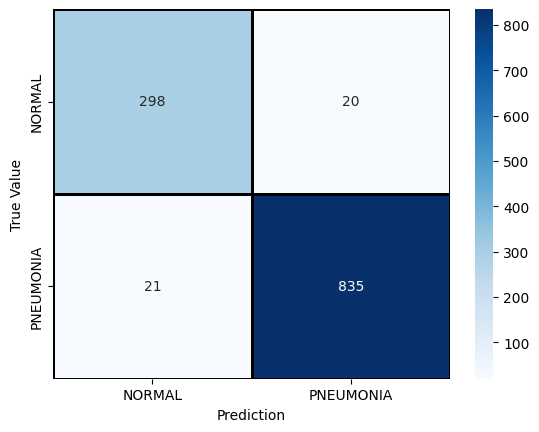

In [128]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
labels = ['NORMAL', 'PNEUMONIA']
predictions = fitted_resnet50_mod.predict(test_data)

y_pred = []
y_true = []

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = fitted_resnet50_mod.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > 0.5, 1,0))

print(y_true)

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)




cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
plt.figure(figsize = (10,10))
ax = sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
ax.set(xlabel= "Prediction", ylabel = "True Value")

In [116]:
fitted_resnet50_mod.predict(test_data)

37/37 [==============================] - 2s 48ms/step


array([[0.9996836 ],
       [1.        ],
       [1.        ],
       ...,
       [0.99998164],
       [1.        ],
       [1.        ]], dtype=float32)

In [123]:
classification_report(true_labels,predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names = ['Normal(Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

    Normal(Class 0)       0.93      0.94      0.94       318
Pneumonia (Class 1)       0.98      0.98      0.98       856

           accuracy                           0.97      1174
          macro avg       0.96      0.96      0.96      1174
       weighted avg       0.97      0.97      0.97      1174



In [125]:
for x,y in test_data:
    print(y)

tf.Tensor([1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 

In [129]:
check_data = keras.utils.image_dataset_from_directory(
    'D:\\Paul_Backup\\paulj\\Pneumonia-Classification\\src\\data_split\\train',

    batch_size=32, 
    seed = 10
)

Found 3512 files belonging to 2 classes.


In [130]:
for x,y in check_data:
    print(x.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 